In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

from fitter import Fitter
import scipy.stats
from scipy.stats import exponnorm, erlang, gennorm

from skmultiflow.drift_detection import PageHinkley
from driftwatch import GreedyKS, IksReservoir, ReservoirSampling, LallDDSketch

In [3]:
def get_file_names():
    files = []
    days = range(1, 23) # 1, 32
    months = range(1, 2) #1, 3
    for month in months:
        month_2_digits = '{month:02}'.format(month=month)
        path = './COVID19_Tweets_Dataset_2020/Summary_Sentiment/2020_' + month_2_digits + '/'

        for day in days:
            if month == 2 and day > 29:
                continue
            if month == 1 and day < 22:
                continue

            for hour in range(24): # 24
                file_name = path + f'2020_{month_2_digits}_' + '{day:02}'.format(day=day) + '_{hour:02}'.format(hour=hour) + '_Summary_Sentiment.csv'
                files.append(file_name)

    return files

In [4]:
def get_dist_obj(dist, param):
    return getattr(scipy.stats, dist)(**param)

In [51]:
def ph_builder(ref_distrib, num_bins):
    return PageHinkley(min_instances=0)

def rs_builder(ref_distrib, num_bins):
    return ReservoirSampling(num_bins, ref_distrib)

def gks_builder(ref_distrib, num_bins):
    return GreedyKS(ref_distrib, num_bins, exact_prob=True)

# def dds_builder(ref_distrib, num_bins, stream):
#     return LallDDSketch(compute_ddsketch_error(stream, num_bins), ref_distrib)

def iks_builder(ref_distrib, num_bins):
    return IksReservoir(num_bins, ref_distrib)

method_factory = {
    'Page Hinkley': ph_builder,
    'Reservoir Sampling': rs_builder,
    'GreedyKS': gks_builder,
    # 'Lall + DDSketch': dds_builder,
    'IKS + RS': iks_builder,
}

methods_colors = {
    "Reservoir Sampling" : 'r',
    "GreedyKS" : 'g',
    "IKS + RS" : 'b',
    'Page Hinkley': 'yellow'

}

methods = ['Page Hinkley','GreedyKS', 'Reservoir Sampling', 'IKS + RS']#, 'Lall + DDSketch']

In [52]:
def run(num_bins):
    files = get_file_names()
    instances_methods = {}
    index = 0
    methods_drifts = {
        "Page Hinkley": [],
        "GreedyKS" : [],
        "Reservoir Sampling" : [],
        "IKS + RS": [],
    }
    methods_times = {
        "Page Hinkley": 0,
        "GreedyKS" : 0,
        "Reservoir Sampling" : 0,
        "IKS + RS" : 0
    }


    for file in files:

        sample = pd.read_csv(file)['Logits_Negative']

        f = Fitter(sample)
        f.fit()
        best_fitted = f.get_best()
        dist = get_dist_obj(list(best_fitted.keys())[0], list(best_fitted.values())[0])
        
        for element in sample:
            index += 1
            for m in methods:
                if m in instances_methods:
                    start = time.time()
                    instances_methods[m].add_element(element)
                    if instances_methods[m].detected_change():
                        methods_drifts[m].append(index)
                        del instances_methods[m]
                    
                    methods_times[m] = methods_times[m] + time.time() - start

        for m in methods:
            if m not in instances_methods:
                instances_methods[m] = method_factory[m](dist, num_bins)
                for element in sample:
                    instances_methods[m].add_element(element)

    print('Number of tweets processed: ', index)

    return methods_drifts, methods_times

In [53]:
methods_drifts, methods_times = run(3000)

Fitting 110 distributions:  99%|█████████▉| 109/110 [01:03<00:04,  4.53s/it]/home/thalis/repositories/TCC/venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitting 110 distributions:  29%|██▉       | 32/110 [00:18<00:52,  1.50it/s]/home/thalis/repositories/TCC/venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3485: IntegrationWarning: The integral is probably diverge

In [ ]:
methods_times

{'Page Hinkley': 0.0008764266967773438,
 'GreedyKS': 29.85616421699524,
 'Reservoir Sampling': 32.085102558135986,
 'IKS + RS': 0.044896602630615234}

In [ ]:
print('Drifts detected')
print('Reservoir Sampling - ', len(methods_drifts['Reservoir Sampling']))
print('GreedyKS - ', len(methods_drifts['GreedyKS']))
print('IKS + RS - ', len(methods_drifts['IKS + RS']))
print('Page Hinkley - ', len(methods_drifts['Page Hinkley']))


Drifts detected
Reservoir Sampling -  1
GreedyKS -  1
IKS + RS -  1
Page Hinkley -  0


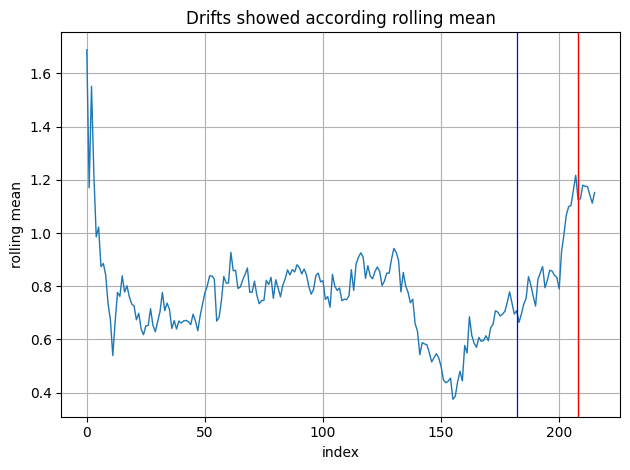

In [ ]:
files = get_file_names()
stream = []
for file in files:
    stream.append(pd.read_csv(file)['Logits_Negative'])
stream = pd.concat(stream, ignore_index=True)


rolling_mean = stream.rolling(len(stream)//10, min_periods=0).mean()

# plt.figure(figsize=(5,3.5))
plt.plot(rolling_mean, linewidth=1)

for m in methods_drifts:
    # if m != 'page hinkley':
    #     continue
    for d in methods_drifts[m]:
        plt.axvline(x = d, color = methods_colors[m], linewidth=0.9, label=m)




plt.title('Drifts showed according rolling mean')
# plt.legend()
plt.xlabel('index')
plt.ylabel('rolling mean')
plt.grid(True)
plt.tight_layout()
plt.show()